## Imports

In [1]:

#utils
import numpy as np 
import pandas as pd
from glob import glob
import tensorflow as tf

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#Preproc
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras import backend as K

#model
from keras import layers
from keras.models import Model
from keras.layers import Conv2D, GlobalMaxPooling2D,MaxPooling2D
from keras.layers import Activation,Dense

#metrics
from sklearn import metrics
from keras.metrics import categorical_accuracy
from sklearn.metrics import classification_report,confusion_matrix,f1_score, precision_score
import time

## Globals

In [2]:
#to make it reproducable
seed = 5
np.random.seed(seed)
#dimensions
img_width, img_height = 64,64
#data dirs
train_data_dir = './mips/train/'
test_data_dir = './mips/val/'
#Classes/labels

class_types = ['Malware','Benign']

In [3]:
#Class/label setup
num_classes = 2 #malware & benignware
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, None)
else:
    input_shape = (img_width, None,1)
input_shape

(64, None, 1)

## Model Description

In [4]:
def model(input_shape):
    input_layer = layers.Input(shape = input_shape)
    x = Conv2D(32,(3,3),activation='relu')(input_layer)
    x = MaxPooling2D(32,(2,2))(x)
    x = Conv2D(72,(3,3),activation='relu')(x)
    x = GlobalMaxPooling2D()(x)
    x = Dense(256,activation='softmax')(x)
    output_layer = Dense(1,activation='sigmoid')(x)
    model = Model(inputs =input_layer,outputs = output_layer,name='CNN')
    return model

In [5]:
model = model(input_shape)

#Compiling
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, None, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, None, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, None, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, None, 72)      20808     
_________________________________________________________________
global_max_pooling2d (Global (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               18688     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257     

## Data Generation

In [6]:
#Use ImageDataGenerator to feed image files from directories
train_datagen = ImageDataGenerator(rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

train_generator = train_datagen.flow_from_directory(
                          train_data_dir,
                          color_mode='grayscale',
                          target_size = (64,64),
                          batch_size = 10,
                          class_mode = 'binary')


test_generator = test_datagen.flow_from_directory(
                  test_data_dir,
                  color_mode='grayscale',
                  target_size=(img_width, img_width),
              batch_size=10,
              class_mode='binary')

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Fitting Model

In [7]:
start_time = time.time()
history = model.fit(train_generator, steps_per_epoch=20, validation_data=test_generator, 
                              validation_steps=20,epochs=20)

print("CNN model execution time took %s seconds" % (time.time() - start_time))

Epoch 1/20
20/20 [==============================] - 11s 493ms/step - loss: 0.6931 - accuracy: 0.5487 - val_loss: 0.6933 - val_accuracy: 0.4800
Epoch 2/20
20/20 [==============================] - 6s 295ms/step - loss: 0.6927 - accuracy: 0.5538 - val_loss: 0.6938 - val_accuracy: 0.4500
Epoch 3/20
20/20 [==============================] - 5s 241ms/step - loss: 0.6921 - accuracy: 0.5724 - val_loss: 0.6933 - val_accuracy: 0.4900
Epoch 4/20
20/20 [==============================] - 5s 252ms/step - loss: 0.6921 - accuracy: 0.5383 - val_loss: 0.6947 - val_accuracy: 0.4450
Epoch 5/20
20/20 [==============================] - 5s 247ms/step - loss: 0.6919 - accuracy: 0.5217 - val_loss: 0.6904 - val_accuracy: 0.5300
Epoch 6/20
20/20 [==============================] - 4s 197ms/step - loss: 0.6930 - accuracy: 0.4566 - val_loss: 0.6870 - val_accuracy: 0.5250
Epoch 7/20
20/20 [==============================] - 4s 187ms/step - loss: 0.6857 - accuracy: 0.4953 - val_loss: 0.6809 - val_accuracy: 0.4850
Epoch

## Metrics

### Confusion Matrix

In [8]:
probabilities = model.predict(test_generator)
y_true = test_generator.classes
y_pred = probabilities>0.49873
plt.rc('font')
mat = confusion_matrix(y_true, y_pred)
mat

array([[163, 237],
       [166, 234]], dtype=int64)

### Precision Score

In [9]:
precision_score = metrics.precision_score(y_true,y_pred,average='macro')
print(f"Test precision : {precision_score:.1%}")

Test precision : 49.6%


### F1 Score

In [11]:
f1_score = metrics.f1_score(y_true,y_pred)
print(f"F1 score :{f1_score: .1%}")

F1 score : 50.9%


### Recall Score

In [10]:
r1 = metrics.recall_score(y_true,y_pred,average = "macro")
print(f"Recall score :{r1: .1%}")

Recall score : 49.6%


## Visualisation

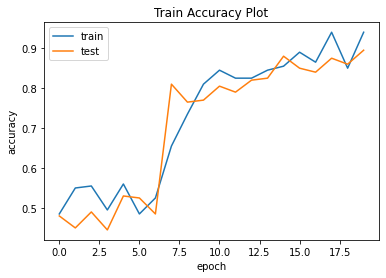

In [11]:
#Summarize history for accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Train Accuracy Plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

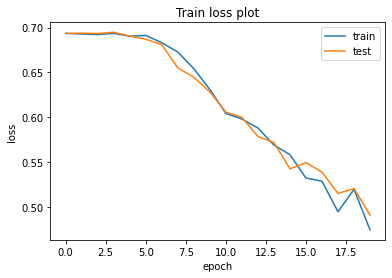

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Train loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

## Heatmap

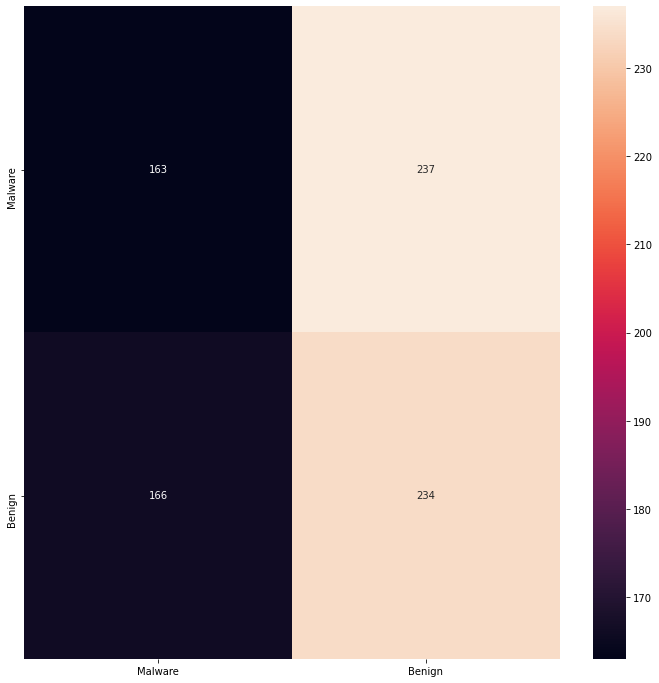

In [13]:
plt.figure(figsize=(12,12))
sns_hmp = sns.heatmap(mat, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
fig = sns_hmp.get_figure()